# COSMOS master catalogue
## Preparation of HST CANDELS-3D data

The catalogue comes from `dmu0_CANDELS-3D-HST`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The kron magnitude, there doesn't appear to be aperture magnitudes. This may mean the survey is unusable.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100)
This notebook was executed on: 
2018-11-06 12:05:33.270406


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "candels_ra"
DEC_COL = "candels_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'ID': "candels_id",
        'RAJ2000': "candels_ra",
        'DEJ2000': "candels_dec",
        'S/G':  "candels_stellarity",
        'F140Wap': "f_ap_candels_f140w",
        'e_F140Wap': "ferr_ap_candels_f140w",
        'F140W': "f_candels_f140w",
        'e_F140W': "ferr_candels_f140w",
        'F160Wap': "f_ap_candels_f160w",
        'e_F160Wap': "ferr_ap_candels_f160w",
        'F160W': "f_candels_f160w",
        'e_F160W': "ferr_candels_f160w",
        'F606W': "f_candels_f606w",
        'e_F606W': "ferr_candels_f606w",
        'F814W': "f_candels_f814w",
        'e_F814W': "ferr_candels_f814w",
        'F125W': "f_candels_f125w",
        'e_F125W': "ferr_candels_f125w"

    })


catalogue = Table.read("../../dmu0/dmu0_CANDELS-3D-HST/data/CANDELS-3D-HST_COSMOS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012 #Year of publication

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        catalogue[col] = catalogue[col] * 0.3631
        catalogue[col].unit = u.microjansky
        catalogue[errcol] = catalogue[errcol] * 0.3631
        catalogue[errcol].unit = u.microjansky
      

        mag, error = flux_to_mag(np.array(catalogue[col]) * 1.e-6 , np.array(catalogue[errcol] ) * 1.e-6)
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:81: RuntimeWarning: divide by zero encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:81: RuntimeWarning: invalid value encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue['candels_stellarity'] = catalogue['candels_stellarity'].astype(float)
catalogue['candels_stellarity'][np.isclose(catalogue['candels_stellarity'], 1.)] = 0.9
catalogue['candels_stellarity'][np.isclose(catalogue['candels_stellarity'], 0.)] = 0.05
catalogue['candels_stellarity'][np.isclose(catalogue['candels_stellarity'], 2.)] = np.nan

In [7]:
catalogue[:10].show_in_notebook()

idx,candels_id,candels_ra,candels_dec,candels_stellarity,f_ap_candels_f140w,ferr_ap_candels_f140w,f_candels_f140w,ferr_candels_f140w,f_ap_candels_f160w,ferr_ap_candels_f160w,f_candels_f160w,ferr_candels_f160w,f_candels_f606w,ferr_candels_f606w,f_candels_f814w,ferr_candels_f814w,f_candels_f125w,ferr_candels_f125w,m_ap_candels_f140w,merr_ap_candels_f140w,m_candels_f140w,merr_candels_f140w,flag_candels_f140w,m_ap_candels_f160w,merr_ap_candels_f160w,m_candels_f160w,merr_candels_f160w,flag_candels_f160w,m_candels_f606w,merr_candels_f606w,flag_candels_f606w,m_candels_f814w,merr_candels_f814w,flag_candels_f814w,m_candels_f125w,merr_candels_f125w,flag_candels_f125w
,,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,
0,1,150.07144165,2.16901445,0.05,nan,nan,nan,nan,1.8110702,0.065597646,2.5702033,0.11964508,1.4882016,0.01217329,3.0544333,0.014993488,2.5597098,0.058371954,nan,nan,nan,nan,False,23.255165,0.039325774,22.875084,0.050541908,False,23.468346,0.008881177,False,22.687675,0.0053296206,False,22.879524,0.024759267,False
1,2,150.07157898,2.16905951,0.05,nan,nan,nan,nan,0.7838602,0.06010394,1.2548009,0.09189697,0.8072076,0.013738251,1.5397619,0.016951323,1.2588676,0.06900352,nan,nan,nan,nan,False,24.164406,0.08325084,23.653564,0.07951529,False,24.132538,0.018478662,False,23.431366,0.011952927,False,23.650055,0.059513498,False
2,3,150.07551575,2.17311358,0.05,nan,nan,nan,nan,6.585544,0.01669897,21.239897,0.1982998,1.7054081,0.028027687,7.052854,0.034523547,16.211687,0.037493706,nan,nan,nan,nan,False,21.853523,0.002753102,20.582123,0.010136643,False,23.320427,0.017843632,False,21.77909,0.0053146514,False,20.875435,0.002511045,False
3,4,150.06834412,2.16974521,nan,nan,nan,nan,nan,0.19595417,0.035028256,0.2369518,0.03287689,0.07290685,0.011539681,0.08186816,0.016118009,0.075666405,0.031453174,nan,nan,nan,nan,False,25.669617,0.19408336,25.463348,0.1506451,False,26.74308,0.17185009,False,26.617218,0.21375714,False,26.702744,0.4513211,False
4,5,150.07145691,2.17064571,nan,nan,nan,nan,nan,0.26412258,0.024869446,0.29932147,0.029539999,0.10092728,0.009796801,0.118642926,0.012246274,0.3497597,0.020667652,nan,nan,nan,nan,False,25.345482,0.10223153,25.209656,0.107151166,False,26.389977,0.10539014,False,26.214394,0.11206924,False,25.04058,0.06415725,False
5,6,150.06959534,2.17076755,nan,nan,nan,nan,nan,0.14297426,0.019896064,0.17788994,0.034232702,0.063669585,0.010683491,0.078560315,0.013464111,0.15688099,0.0174898,nan,nan,nan,nan,False,26.011856,0.15108927,25.77462,0.2089364,False,26.890175,0.182182,False,26.661995,0.1860796,False,25.91108,0.121042766,False
6,7,150.06835938,2.17106199,0.05,nan,nan,nan,nan,1.1017543,0.024495816,1.4720073,0.05348463,0.47264725,0.011264088,0.72147965,0.014405266,1.0877386,0.023628732,nan,nan,nan,nan,False,23.794792,0.024139678,23.480225,0.039449666,False,24.713661,0.025875168,False,24.254448,0.021678116,False,23.808685,0.023585234,False
7,8,150.06916809,2.17103839,nan,nan,nan,nan,nan,0.12354114,0.020280587,0.1725197,0.044588678,0.040282313,0.012203065,0.037588112,0.015245843,0.12505889,0.019706527,nan,nan,nan,nan,False,26.170471,0.17823508,25.8079,0.28061455,False,27.387215,0.3289113,False,27.46238,0.44037756,False,26.157219,0.1710881,False
8,9,150.07997131,2.17103219,0.05,nan,nan,nan,nan,0.2481389,0.04266788,0.46883473,0.0999106,0.11358857,0.016694974,0.21560514,0.02044616,0.44359925,0.06018745,nan,nan,nan,nan,False,25.413261,0.18669406,24.72245,0.23137483,False,26.261665,0.15957889,False,25.56585,0.102961995,False,24.782524,0.14731245,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:

SORT_COLS = ['merr_candels_f140w', 
             'merr_candels_f160w', 
             'merr_candels_f606w', 
             'merr_candels_f814w',
             'merr_candels_f125w']
FLAG_NAME = 'candels_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 33879 sources.
The cleaned catalogue has 33869 sources (10 removed).
The cleaned catalogue has 10 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


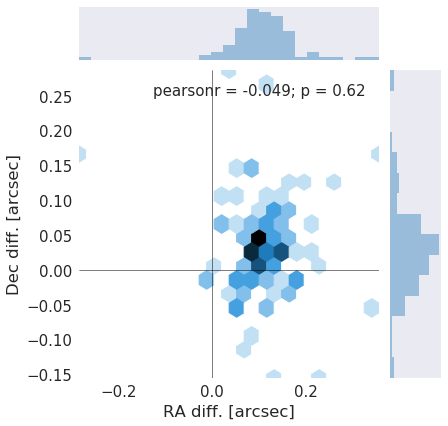

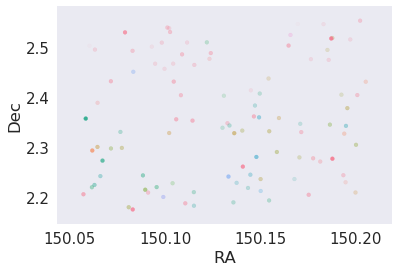

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.10791846540882943 arcsec
Dec correction: -0.028431532331651965 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


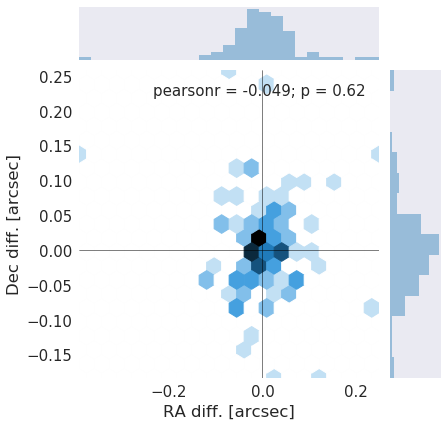

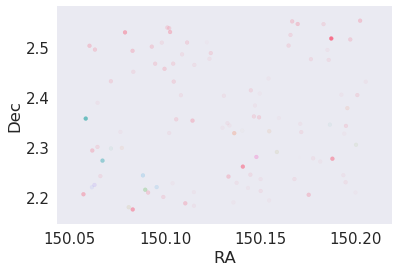

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "candels_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

110 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/CANDELS.fits".format(OUT_DIR), overwrite=True)